<a href="https://colab.research.google.com/github/Ghonem22/instance_detection_and_segmentation/blob/master/instance_detection_and_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test The GPU

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!rm -rf Mask_RCNN
!rm -rf coco

In [5]:
!pip install Cython

In [6]:
!git clone https://github.com/waleedka/coco

Cloning into 'coco'...
remote: Enumerating objects: 904, done.
remote: Total 904 (delta 0), reused 0 (delta 0), pack-reused 904
Receiving objects: 100% (904/904), 10.38 MiB | 958.00 KiB/s, done.
Resolving deltas: 100% (542/542), done.


In [0]:
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

#Cloning MaskRnn

In [0]:
!git clone https://github.com/matterport/Mask_RCNN

#Import coco weights

In [0]:
import os
#select Mask_RCNN Dir
os.chdir('./Mask_RCNN')
# put this file "mask_rcnn_coco.h5" at Mask_RCNN Dir
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [10]:
import sys
sys.path.append('/content/Mask_RCNN/samples/coco')
sys.path.append('/content/Mask_RCNN/mrcnn')
!ls

assets	LICENSE      mask_rcnn_coco.h5	README.md	  samples    setup.py
images	MANIFEST.in  mrcnn		requirements.txt  setup.cfg


#connect the Notepad with drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p drive
!google-drive-ocamlfuse drive


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/bin/bash: google-drive-ocamlfuse: command not found


#Import required libraries

In [11]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()    #getcwd used to returns the current working directory of a process

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)  # burasi kaldirilabilir

# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, "images")
IMAGE_DIR='drive/My Drive/Vision'

Using TensorFlow backend.


In [0]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

#Creating the model

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

#upload your own image from drive

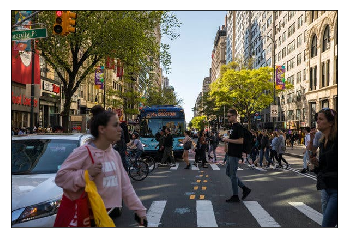

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

img = cv2.imread('drive/My Drive/Vision/x1.jpg')
b,g,r = cv2.split(img)       # get b,g,r
image = cv2.merge([r,g,b])     # switch it to rgb

plt.imshow(image)
plt.xticks([]), plt.yticks([])   # to hide tick values on X and Y axis
plt.show()

In [15]:
# Run detection
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (400, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


#Visualize the result

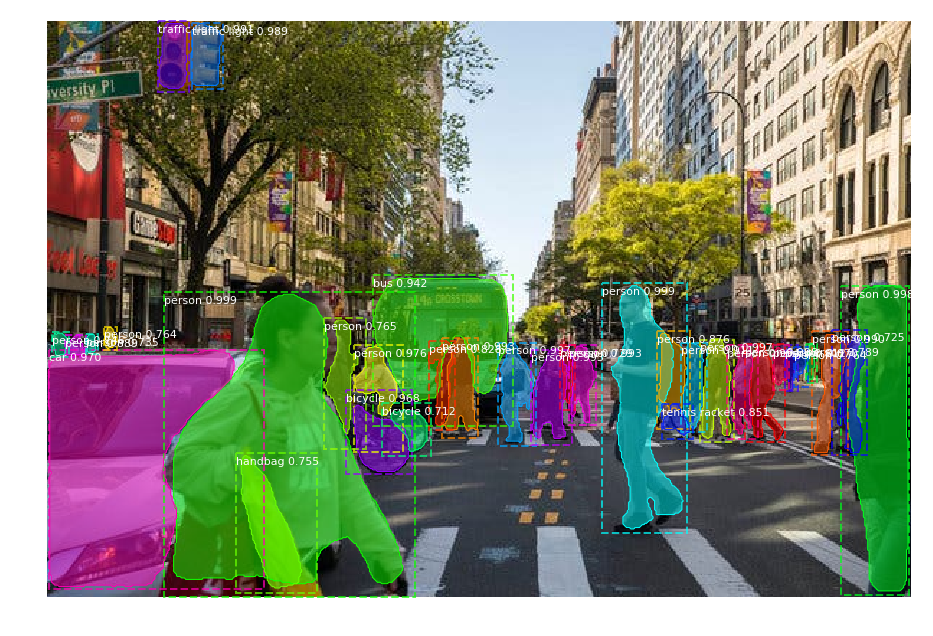

In [16]:
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])